# Tracking the Smoke Caused by the fires

In this example we show how to use [HRRR Smoke Experimental dataset](https://data.planetos.com/datasets/noaa_hrrr_wrf_smoke) to analyse smoke in the US and we will also download historical fire data from [Cal Fire](https://www.fire.ca.gov/incidents) web page to visualize burned area since 2013.

[The High-Resolution Rapid Refresh Smoke (HRRRSmoke)](https://data.planetos.com/datasets/noaa_hrrr_wrf_smoke) is a three-dimensional model that allows simulation of mesoscale flows and smoke dispersion over complex terrain, in the boundary layer and aloft at high spatial resolution over the CONUS domain. The smoke model comprises a suite of fire and environmental products for forecasters during the fire weather season. Products derived from the HRRRSmoke model include the Fire Radiative Power (FRP), Near-Surface Smoke (PM2.5), and Vertically Integrated Smoke, to complement the 10-meter winds, 1-hour precipitation, 2-meter temperature and surface visibility experimental forecast products. Keep in mind, that this dataset is EXPERIMENTAL. Therefore, they should not be used to make decisions regarding safety of life or property.

HRRR Smoke has many different weather parameters, two of them are directly smoke related - Column-integrated mass density and Mass density (concentration) @ Specified height level above ground. First is vertically-integrated smoke and second smoke on the lowest model level (8 m). 

As we would like to have data about the Continental United States we will download data by using Package API. Then we will create a widget where you can choose timestamp by using a slider. After that, we will also save the same data as a GIF to make sharing the results with friends and colleagues more fun. And finally, we will compare smoke data with CAMS particulate matter data to find out if there's a colleration between them as HRRR Smoke is still experimental.

In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import dh_py_access.lib.datahub as datahub
import xarray as xr
import matplotlib.pyplot as plt
import ipywidgets as widgets
from mpl_toolkits.basemap import Basemap,shiftgrid
import dh_py_access.package_api as package_api
import matplotlib.colors as colors
import warnings
import datetime
import shutil
import imageio
import seaborn as sns
import pandas as pd
import os
import matplotlib as mpl
import wget
warnings.filterwarnings("ignore")

<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [2]:
server = 'api.planetos.com'
API_key = open('APIKEY').readlines()[0].strip() #'<YOUR API KEY HERE>'
version = 'v1'

At first, we need to define the dataset name and a variable we want to use.

In [3]:
dh = datahub.datahub(server,version,API_key)
dataset = 'noaa_hrrr_wrf_smoke'
variable_name1 = 'Mass_density_concentration_height_above_ground'

Then we define spatial range. We decided to analyze US, where unfortunately catastrofic wildfires are taking place at the moment and influeces air quality. 

In [4]:
# reftime = datetime.datetime.strftime(datetime.datetime.today(), '%Y-%m-%d') + 'T00:00:00'
area_name = 'usa'
today_hr = datetime.datetime.strftime(datetime.datetime.today(),'%Y%m%dT%H')

latitude_north = 49; longitude_west = -127
latitude_south = 26; longitude_east = -70.5

### Download the data with package API

1. Create package objects
2. Send commands for the package creation
3. Download the package files

In [5]:
package_hrrr = package_api.package_api(dh,dataset,variable_name1,longitude_west,longitude_east,latitude_south,latitude_north,area_name=area_name+today_hr)

In [6]:
package_hrrr.make_package()

http://api.planetos.com/v1/packages?apikey=03d010c205c84acd98ac21e3f1827662&dataset=noaa_hrrr_wrf_smoke&package=noaa_hrrr_wrf_smoke_recent_reftime_20201014_usa20201014T19&z=all&polygon=%5B%5B-127%2C+26%5D%2C+%5B-70.5%2C+26%5D%2C+%5B-70.5%2C+49%5D%2C+%5B-127%2C+49%5D%2C+%5B-127%2C+26%5D%5D&reftime_recent=true&var=Mass_density_concentration_height_above_ground


In [7]:
package_hrrr.download_package()

### Work with the downloaded files

We start with opening the files with xarray. After that, we will create a map plot with a time slider, then make a GIF using the images, then we will do the same thing for closer area - California; and finally, we will download csv file about fires in California to visualize yearly incidents data as a bar chart.

In [8]:
dd1 = xr.open_dataset(package_hrrr.local_file_name)
dd1['longitude'] = ((dd1.lon+180) % 360) - 180
dd1[variable_name1].data[dd1[variable_name1].data < 0] = 0
dd1[variable_name1].data[dd1[variable_name1].data == np.nan] = 0

Here we are making a Basemap of the US that we will use for showing the data.

In [9]:
m = Basemap(projection='merc', lat_0 = 55, lon_0 = -4,
         resolution = 'h', area_thresh = 0.05,
         llcrnrlon=longitude_west, llcrnrlat=latitude_south,
         urcrnrlon=longitude_east, urcrnrlat=latitude_north)
lons,lats = np.meshgrid(dd1.longitude.data,dd1.lat.data)
lonmap,latmap = m(lons,lats)

Now it is time to plot all the data. A great way to do it is to make an interactive widget, where you can choose time stamp by using a slider. 

As the minimum and maximum values are very different, we are using logarithmic colorbar to visualize it better.

On the map we can see that the areas near fires have more smoke, but it travels pretty far. Depending on when the notebook is run, we can see very different results.

But first we define minimum, maximum and also colormap.

In [10]:
vmax = np.nanmax(dd1[variable_name1].data)
vmin = 2

cmap = mpl.cm.twilight.colors[:-100]
tmap = mpl.colors.LinearSegmentedColormap.from_list('twilight_edited', cmap)


In [11]:
def loadimg(k):
    fig=plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    pcm = m.pcolormesh(lonmap,latmap,dd1[variable_name1].data[k][0],
                norm = colors.LogNorm(vmin=vmin, vmax=vmax),cmap = tmap)
    ilat,ilon = np.unravel_index(np.nanargmax(dd1[variable_name1].data[k][0]),dd1[variable_name1].data[k][0].shape)
    cbar = plt.colorbar(pcm,fraction=0.024, pad=0.040,ticks=[10**0, 10**1, 10**2,10**3])
    cbar.ax.set_yticklabels([0,10,100,1000]) 
    ttl = plt.title('Near Surface Smoke ' + str(dd1[variable_name1].time[k].data)[:-10],fontsize=20,fontweight = 'bold')
    ttl.set_position([.5, 1.05])
    cbar.set_label(dd1[variable_name1].units)

    m.drawcountries()
    m.drawstates()
    m.drawcoastlines()
    print("Maximum: ","%.2f" % np.nanmax(dd1[variable_name1].data[k][0]))

    plt.show()
widgets.interact(loadimg, k=widgets.IntSlider(min=0,max=len(dd1[variable_name1].data)-1,step=1,value=0, layout=widgets.Layout(width='100%')))

interactive(children=(IntSlider(value=0, description='k', layout=Layout(width='100%'), max=47), Output()), _do…

<function __main__.loadimg(k)>

Let's include an image from the last time-step as well, because GitHub Preview doesn't show the time slider images. 

Maximum:  634.74


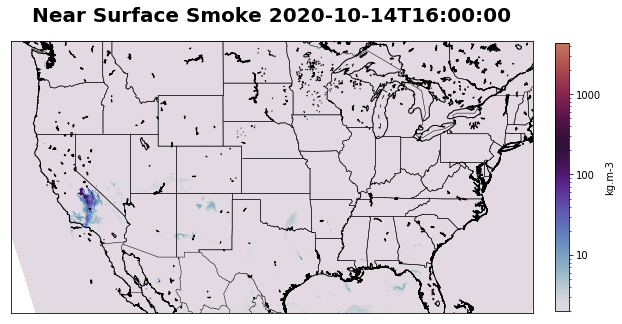

In [12]:
loadimg(9)

With the function below we will save images you saw above to the local filesystem as a GIF, so it is easily shareable with others. 

In [13]:
def make_ani(m,lonmap,latmap,aniname,smaller_area=False):
    if smaller_area==True:
        fraction = 0.035
        fontsize = 13
    else:
        fraction = 0.024
        fontsize = 20
        
    folder = './anim/'
    for k in range(len(dd1[variable_name1])):
        filename = folder + 'ani_' + str(k).rjust(3,'0') + '.png'
        if not os.path.exists(filename):
            fig=plt.figure(figsize=(10,7))
            ax = fig.add_subplot(111)
            pcm = m.pcolormesh(lonmap,latmap,dd1[variable_name1].data[k][0],
            norm = colors.LogNorm(vmin=vmin, vmax=vmax),cmap = tmap)

            m.drawcoastlines()
            m.drawcountries()
            m.drawstates()
            cbar = plt.colorbar(pcm,fraction=fraction, pad=0.040,ticks=[10**0, 10**1, 10**2,10**3])
            cbar.ax.set_yticklabels([0,10,100,1000]) 
            ttl = plt.title('Near Surface Smoke ' + str(dd1[variable_name1].time[k].data)[:-10],fontsize=fontsize,fontweight = 'bold')
            ttl.set_position([.5, 1.05])
            cbar.set_label(dd1[variable_name1].units)
            ax.set_xlim()
            if not os.path.exists(folder):
                os.mkdir(folder)
            plt.savefig(filename,bbox_inches = 'tight',dpi=150)
            plt.close()

    files = sorted(os.listdir(folder))
    images = []
    for file in files:
        if not file.startswith('.'):
            filename = folder + file
            images.append(imageio.imread(filename))
    kargs = { 'duration': 0.3,'quantizer':2,'fps':5.0}
    imageio.mimsave(aniname, images, **kargs)
    print ('GIF is saved as {0} under current working directory'.format(aniname))
    shutil.rmtree(folder)
make_ani(m,lonmap,latmap,'hrrr_smoke.gif')

GIF is saved as hrrr_smoke.gif under current working directory


As we are interested in California fires right now, it would make sense to make animation of only California area as well. So people can be prepared when smoke hits their area. The model has pretty good spatial resolution as well - 3 km, which makes tracking the smoke easier. 

In [14]:
latitude_north_cal = 43; longitude_west_cal = -126.
latitude_south_cal = 30.5; longitude_east_cal = -113

m2 = Basemap(projection='merc', lat_0 = 55, lon_0 = -4,
         resolution = 'h', area_thresh = 0.05,
         llcrnrlon=longitude_west_cal, llcrnrlat=latitude_south_cal,
         urcrnrlon=longitude_east_cal, urcrnrlat=latitude_north_cal)
lons2,lats2 = np.meshgrid(dd1.longitude.data,dd1.lat.data)
lonmap_cal,latmap_cal = m2(lons2,lats2)

In [15]:
make_ani(m2,lonmap_cal,latmap_cal,'hrrr_smoke_california.gif',smaller_area=True)

GIF is saved as hrrr_smoke_california.gif under current working directory


Finally, we will remove the package we downloaded. 

In [16]:
os.remove(package_hrrr.local_file_name)

# Data about Burned Area from Cal Fire
Now we will download csv file from Cal Fire web page and illustrate how many acres each year was burnt since 2013. 

In [17]:
wget.download('https://www.fire.ca.gov/imapdata/mapdataall.csv',out='acres_burned.csv')

'acres_burned.csv'

In [18]:
datain = pd.read_csv('acres_burned.csv')

Here we convert `incident_dateonly_created` column to datetime, so it's easier to group data by year.

In [19]:
datain['incident_dateonly_created'] = pd.to_datetime(datain['incident_dateonly_created'])

Below you can see the data from `acres_burned.csv` file. It has information about each incident. This time we only compute total acres burned each year. 

In [20]:
datain

,incident_name,incident_is_final,incident_date_last_update,incident_date_created,incident_administrative_unit,incident_administrative_unit_url,incident_county,incident_location,incident_acres_burned,incident_containment,...,incident_latitude,incident_type,incident_id,incident_url,incident_date_extinguished,incident_dateonly_extinguished,incident_dateonly_created,is_active,calfire_incident,notification_desired
0,Bridge Fire,True,2018-01-09 13:46:00,2017-10-31 11:22:00,Shasta-Trinity National Forest,NaN,Shasta,"I-5 and Turntable Bay, 7 miles NE of Shasta Lake",37,100,...,40.774000,NaN,2ca11d45-8139-4c16-8af0-880d99b21e82,https://www.fire.ca.gov/incidents/2017/10/31/b...,2018-01-09 13:46:00,2018-01-09,2017-10-31,N,False,False
1,Pala Fire,True,2020-09-16 14:07:35,2009-05-24 14:56:00,CAL FIRE San Diego Unit,NaN,San Diego,"Hwy 76 and Pala Temecula, northwest of Pala",122,100,...,1.000000,Wildfire,8f61f461-552d-4538-b186-35ab030da416,https://www.fire.ca.gov/incidents/2009/5/24/pa...,2009-05-25 00:00:00,2009-05-25,2009-05-24,N,True,False
2,River Fire,True,2013-02-28 20:00:00,2013-02-24 08:16:00,CAL FIRE San Bernardino Unit,NaN,Inyo,"south of Narrow Gauge Rd & north of Hwy 136, e...",406,100,...,36.602575,NaN,094719ba-a47b-4abb-9ec5-a506b2b9fd23,https://www.fire.ca.gov/incidents/2013/2/24/ri...,2013-02-28 20:00:00,2013-02-28,2013-02-24,N,True,False
3,Fawnskin Fire,True,2013-04-22 09:00:00,2013-04-20 17:30:00,San Bernardino National Forest,NaN,San Bernardino,"west of Delamar Mountain, north of the communi...",30,100,...,34.288877,NaN,58f89ff8-bd3e-4355-b1c0-8fa05c747d3f,https://www.fire.ca.gov/incidents/2013/4/20/fa...,2013-04-22 09:00:00,2013-04-22,2013-04-20,N,False,False
4,Gold Fire,True,2013-05-01 07:00:00,2013-04-30 12:59:00,CAL FIRE Madera-Mariposa-Merced Unit,NaN,Madera,Between Road 210 and Road 200 near Fine Gold C...,274,100,...,37.116295,NaN,357ffc13-bef9-48eb-810f-c5de851972eb,https://www.fire.ca.gov/incidents/2013/4/30/go...,2013-05-01 07:00:00,2013-05-01,2013-04-30,N,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1711,Pony Fire,True,2020-10-04 07:22:52,2020-10-03 15:38:00,CAL FIRE/ Amador-El Dorado Unit,NaN,Sacramento,"Pony Brown Rd and Ione Rd, Sloughhouse",20,100,...,38.464074,Wildfire,745a276b-488e-40e6-b62d-065111a98139,https://www.fire.ca.gov/incidents/2020/10/3/po...,2020-10-04 07:22:00,2020-10-04,2020-10-03,N,True,False
1712,Lambert Fire,True,2020-10-06 19:05:45,2020-10-04 12:46:20,CAL FIRE Amador El Dorado Unit,NaN,Amador,"Lambert Road and Carbondale Road, North of Car...",21,100,...,38.424016,Wildfire,8b25feb1-9eb7-433d-8abf-d6ab554c9fe3,https://www.fire.ca.gov/incidents/2020/10/4/la...,2020-10-06 19:04:00,2020-10-06,2020-10-04,N,True,False
1713,Fields Fire,True,2020-10-07 08:35:45,2020-10-07 06:06:33,CAL FIRE Nevada Yuba Placer Unit,NaN,Yuba,"Gold Field Road and Hammonton Road, Northeast ...",56,100,...,39.181047,Wildfire,b341b09d-2024-4b2a-a439-f39409abb432,https://www.fire.ca.gov/incidents/2020/10/7/fi...,2020-10-07 08:34:00,2020-10-07,2020-10-07,N,True,False
1714,Irvine Fire,True,2020-10-12 06:12:20,2020-10-11 18:04:00,CALFIRE/ Santa Clara Unit,NaN,Contra Costa,Irvine Drive in Moraga,30,100,...,37.821737,Wildfire,65b0ce28-b5e6-4dfc-b569-96716e556c90,https://www.fire.ca.gov/incidents/2020/10/11/i...,2020-10-12 00:00:00,2020-10-12,2020-10-11,N,True,False


Computing yearly sums. In some reason there's many years without much data, so we will filter it out. Also, reseting index, as we don't want dates to be as an index and making year column. 

In [21]:
burned_acres_yearly = datain.resample('1AS', on='incident_dateonly_created')['incident_acres_burned'].sum()
burned_acres_yearly = burned_acres_yearly[burned_acres_yearly.index > datetime.datetime(2012,1,1)]
burned_acres_yearly = burned_acres_yearly.reset_index()
burned_acres_yearly['year'] = pd.DatetimeIndex(burned_acres_yearly.incident_dateonly_created).year

We can see the computed data below.

In [22]:
burned_acres_yearly

,incident_dateonly_created,incident_acres_burned,year
0,2013-01-01,496937,2013
1,2014-01-01,297186,2014
2,2015-01-01,413462,2015
3,2016-01-01,452406,2016
4,2017-01-01,1455280,2017
5,2018-01-01,1571007,2018
6,2019-01-01,285439,2019
7,2020-01-01,2875603,2020


Finally we will make a bar chart of the data. We are using [seaborn](https://seaborn.pydata.org/) this time for plotting the data and to visualize it better, we added colormap to bar chart as well. 
Image will be saved into the working directory. 

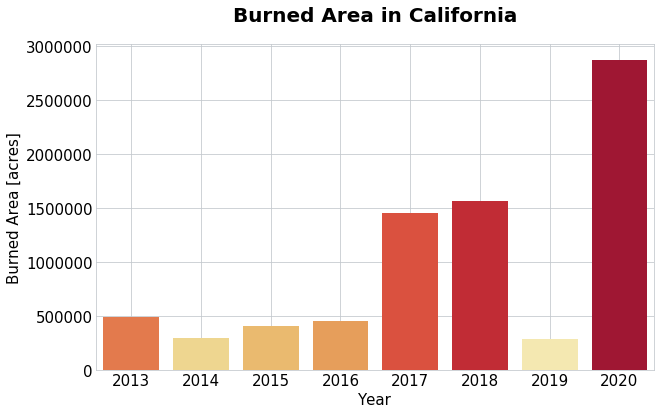

In [23]:
fig,ax = plt.subplots(figsize=(10,6))
pal = sns.color_palette("YlOrRd_r", len(burned_acres_yearly))
rank = burned_acres_yearly['incident_acres_burned'].argsort().argsort()

sns.barplot(x='year',y='incident_acres_burned',data=burned_acres_yearly,ci=95,ax=ax,palette=np.array(pal[::-1])[rank])
ax.set_xlabel('Year',fontsize=15)

ax.set_ylabel('Burned Area [acres]',fontsize=15)
ax.grid(color='#C3C8CE',alpha=1)
ax.set_axisbelow(True)
ax.spines['bottom'].set_color('#C3C8CE')
ax.spines['top'].set_color('#C3C8CE')
ax.spines['left'].set_color('#C3C8CE')
ax.spines['right'].set_color('#C3C8CE')
ttl = ax.set_title('Burned Area in California',fontsize=20,fontweight = 'bold')
ttl.set_position([.5, 1.05])
ax.tick_params(labelsize=15,length=0)
plt.savefig('acres_burned_cali.png',dpi=300)